## Градиентный бустинг своими руками

Композиция на N шаге:
$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

$\nu$ — гиперпараметр learning rate, $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма, который можно найти по следующей формуле:

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$

In [ ]:
from scipy.optimize import minimize

In [ ]:
class GradientBoosting():
    def __init__(self, n_estimators=100, max_depth=7, learning_rate=0.1, optimal_gamma= True, max_features= 1.0):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.trees = [] #сохраняем сюда деревья
        self.optimal_gamma = optimal_gamma # оптимальная gamma или нет
        self.gamma = []
        self.max_features = max_features

    def fit(self, x, y):
        """
        INPUT:
        x - np.array of shape (k, d)
        y - np.array of shape (k,)
        """
        # Итерации по n_estimators и обучение
        # соответствующего количества деревьев с помощью _fit_predict_tree()
        self.X = x
        self.y = y
        pred = np.zeros(y.shape[0])
        for t in range(self.n_estimators):
          if t==0:
            pred = self._fit_predict_tree(x,y,pred)
            y_new = y - pred #антиградиент для MSE
          else:
            pred += self._fit_predict_tree(x,y_new,pred)
            y_new = y - pred
        return self


    def _fit_predict_tree(self, x, y, pred):
        # Обучаем дерево и возвращаем его предикшн
        tree = DecisionTreeRegressor(max_depth = self.max_depth,max_features= self.max_features , random_state=19052019)
        tree.fit(x,y)
        self.trees.append(tree)
        if self.optimal_gamma == True:
          # нахождение оптимальной гаммы
          gamma = minimize(lambda g: (np.sum((self.y - (pred + g * tree.predict(x)))**2))/len(self.y),0.5,method='BFGS').x[0]
          self.gamma.append(gamma)
          return gamma * self.learning_rate * tree.predict(x)
        else:
          self.gamma.append(1)
          return self.learning_rate * tree.predict(x)
        
    def predict(self, x):
        """
        INPUT:
        x - np.array of shape (m, d)
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        # Используем сохранённые деревья для расчёта агрегированного предикшна
        y_pred = np.zeros(x.shape[0])
        for i in range(0,self.n_estimators):
          y_pred += self.learning_rate * self.gamma[i] * self.trees[i].predict(x)
        return y_pred



Проверка реализации на Boston dataset. Сид подобран так чтобы решающие деревья выдавали плохой результат.

In [ ]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=4, n_estimators=640, random_state=19052019)

rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

9.635844078917064

In [ ]:
np.random.seed(19052019)
gb = GradientBoosting(n_estimators= 94, max_depth = 4, learning_rate= 0.05,optimal_gamma= False, max_features= 0.5)
gb.fit(X_train, y_train)
mean_squared_error(y_test, gb.predict(X_test))

8.11193292089421

In [ ]:
np.random.seed(19052019)
gb = GradientBoosting(n_estimators= 94 , max_depth = 4 ,learning_rate= 0.05,optimal_gamma= True, max_features= 0.5)
gb.fit(X_train, y_train)
mean_squared_error(y_test, gb.predict(X_test))

8.378790928214489

## Прогноз задержки самолётов

На основании доступных данных о рейсе нужно определить, будет ли он задержан на 15 минут.

In [ ]:
import pandas as pd

In [ ]:
train = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering/flight_delays_train.csv')

In [ ]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [ ]:
# Референс
from xgboost.sklearn import XGBClassifier
X_train = train[['Distance', 'DepTime']].values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3,shuffle=True)

xgb = XGBClassifier(n_jobs = -1)
xgb.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, xgb.predict_proba(X_valid)[:, 1])

0.7000607807325846

In [ ]:
X_train = train[['Distance', 'DepTime',	'UniqueCarrier','Origin','Dest','Month',	'DayofMonth',	'DayOfWeek']].values
X_test = test[['Distance', 'DepTime',	'UniqueCarrier','Origin','Dest','Month',	'DayofMonth',	'DayOfWeek']].values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3,shuffle=True)

In [ ]:
!pip install catboost
import catboost
from catboost import CatBoostClassifier

In [ ]:
cat_features=[2,3,4,5,6,7]

In [ ]:
grid = CatBoostClassifier(eval_metric='AUC', early_stopping_rounds=40, learning_rate=0.1, depth=6, cat_features=cat_features)
grid.fit(X_train_part, y_train_part, eval_set=(X_valid, y_valid), use_best_model=True, verbose=True,cat_features=cat_features)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	test: 0.6568125	best: 0.6568125 (0)	total: 69.5ms	remaining: 1m 9s
1:	test: 0.6805931	best: 0.6805931 (1)	total: 188ms	remaining: 1m 34s
2:	test: 0.6821158	best: 0.6821158 (2)	total: 236ms	remaining: 1m 18s
3:	test: 0.6837312	best: 0.6837312 (3)	total: 363ms	remaining: 1m 30s
4:	test: 0.6831514	best: 0.6837312 (3)	total: 429ms	remaining: 1m 25s
5:	test: 0.6831253	best: 0.6837312 (3)	total: 478ms	remaining: 1m 19s
6:	test: 0.6834167	best: 0.6837312 (3)	total: 532ms	remaining: 1m 15s
7:	test: 0.6857535	best: 0.6857535 (7)	total: 612ms	remaining: 1m 15s
8:	test: 0.6891064	best: 0.6891064 (8)	total: 681ms	remaining: 1m 14s
9:	test: 0.6910321	best: 0.6910321 (9)	total: 787ms	remaining: 1m 17s
10:	test: 0.6953587	best: 0.6953587 (10)	total: 903ms	remaining: 1m 21s
11:	test: 0.6948696	best: 0.6953587 (10)	total: 961ms	remaining: 1m 19s
12:	test: 0.6956405	best: 0.6956405 (12)	total: 1.06s	remaining: 1m 20s
13:	test: 0.6975162	best: 0.6975162 (13)	total: 1.15s	remaining: 1m 21s
14:	test: 0.

In [ ]:
grid.get_feature_importance()

array([ 7.90339904, 40.57282911, 11.23043096,  9.73288934, 10.59436275,
        7.79368185,  6.15888925,  6.0135177 ])

In [ ]:
roc_auc_score(y_valid, grid.predict_proba(X_valid)[:, 1])

0.7623028601371812

Точность на выборке для обучения

## DBSCAN своими руками

In [ ]:
from scipy.spatial import distance

In [ ]:
class dbscan:
    def __init__(self, eps, min_samples):

        self.eps = eps
        self.min_samples = min_samples
        self.x = []
        self.noted = []
        self.current = 0
        self.data = []

    def fit_predict(self, X):
      self.data = X.copy()
      self.noted = [0]*X.shape[0]
      if X.shape[0]!=len(self.noted):
        print(X.shape[0])
        print(len(self.noted))
      for i in range(X.shape[0]):
        
        if self.noted[i] is not 0:
          continue

        neighbours = self.range_query(i)

        if len(neighbours) < self.min_samples:
          self.noted[i] = -1

        else:
          self.current +=1
          self.grow_cluster(i,neighbours)

      return self.noted 
        # Помечаем переданные точки, чтобы отличать уже кластеризованные
        # или являющиеся шумом от остальных
        # Реализуем цикл по точкам, игнорирущий уже кластеризованные
        # Если точка ещё не кластеризована, с помощью range_query() ищем её соседей
        # Если соседей недостаточно, то помечаем её выделенным под шум лейблом
        # (однако она ещё может попасть в какой-то иной кластер)
        # Если же соседей достаточно, будем строить от неё кластер с помощью grow_cluster()

    def grow_cluster(self, root, neighbours):

        self.noted[root] = self.current
        
        i = 0

        while(i < len(neighbours)-1):
            next = neighbours[i]  

            if self.noted[next] == -1:
                self.noted[next] = self.current

            elif self.noted[next] == 0:
                self.noted[next] = self.current
                next_neighbours = self.range_query(next)

                if len(next_neighbours) >= self.min_samples:
                    neighbours += next_neighbours
            i+=1
        return self
        # В этой функции мы полностью строим кластер относительно переданной точки
        # Т.е. реализуем цикл по структуре данных, изначально состоящей из уже
        # известных соседей (neighbours) и в процессе пополняющейся
        # "соседями соседей" с помощью range_query()

    def range_query(self, x):
        """Возвращает точки на расстоянии <= eps от x"""
        points = []
        for i in range(len(self.data)):
          if self.dist(self.data[x],self.data[i]) <= self.eps:
            points.append(i)
        return points
    
    @staticmethod
    def dist(a, b):
        """Метрика расстояния"""
        return distance.euclidean(a,b)

Простой пример:

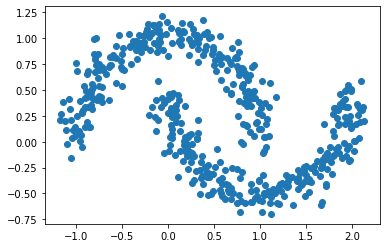

In [ ]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd

X, _ = make_moons(n_samples=500, noise=0.1)
plt.scatter(X[:,0], X[:,1])
plt.show()

Моя версия DBSCAN:

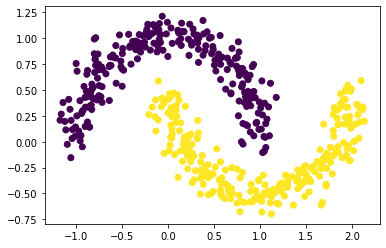

In [ ]:
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Референс:

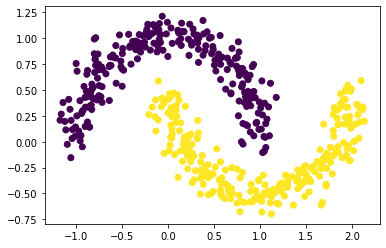

In [ ]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Пример поинтереснее:

In [ ]:
from sklearn import datasets
noisy_circles,_ = datasets.make_circles(n_samples=1500, factor=.7,
                                      noise=.04)
noisy_moons,_ = datasets.make_moons(n_samples=500, noise=.05)

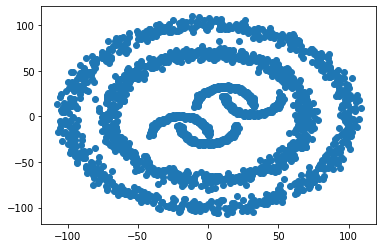

In [ ]:
data = noisy_circles*100
data = np.append(data, (noisy_moons + 0.6)*20,axis=0)
data = np.append(data, (noisy_moons - 1)*20,axis=0)
plt.scatter(data[:,0], data[:,1])
plt.show()

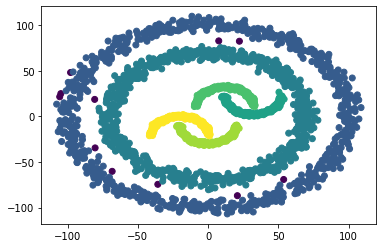

In [ ]:
from sklearn.cluster import DBSCAN

clusters = dbscan(eps=6.7, min_samples=6).fit_predict(data)

plt.scatter(data[:,0], data[:,1] , c=clusters)
plt.show()

Сравнение скорости работы алгоритмов:

In [ ]:
%%time
%%capture
clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

CPU times: user 8.52 ms, sys: 0 ns, total: 8.52 ms
Wall time: 10.7 ms


In [ ]:
%%time
%%capture
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

CPU times: user 3 s, sys: 7.81 ms, total: 3.01 s
Wall time: 3.02 s
